**FILTERIING VCFs - PART 2. STATISTICS VISUALIZATION IN R**

In the first part of the filtering pipeline we took a raw vcf from the 200kexomes folder as reference to analyze the trends of the data to set the filters to select only the best quality, biallelic variants. The steps of Part 1 are documented at: vcf-filtering.bash. 
In the part 1 we calculated VCF statistics such as: read deep, read quality, MAF and we identified the missing data. In this Part 2. we are going to visualize the trends of those statistics in our dataset to se t the treshold for the filtering parameters. 

In [1]:
#Setting up the R environment. 
# First, load tidyverse package. 

In [2]:
library(tidyverse)

Registered S3 methods overwritten by 'ggplot2':
  method         from 
  [.quosures     rlang
  c.quosures     rlang
  print.quosures rlang
Registered S3 method overwritten by 'rvest':
  method            from
  read_xml.response xml2
── Attaching packages ─────────────────────────────────────── tidyverse 1.2.1 ──
✔ ggplot2 3.1.1       ✔ purrr   0.3.2  
✔ tibble  2.1.1       ✔ dplyr   0.8.0.1
✔ tidyr   0.8.3       ✔ stringr 1.4.0  
✔ readr   1.3.1       ✔ forcats 0.4.0  
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()


**PER VARIANT ANALYSIS**

**Variant Quality**
The first metric we will look at is the (Phred encoded) site quality. This is a measure of how much confidence we have in our variant calls.

In [3]:
var_qual <- read_delim("./vcftools-out/vcftools-out.lqual", delim = "\t",
           col_names = c("chr", "pos", "qual"), skip = 1)

Parsed with column specification:
cols(
  chr = col_character(),
  pos = col_double(),
  qual = col_double()
)


In [4]:
print (var_qual)

# A tibble: 80 x 3
   chr       pos  qual
   <chr>   <dbl> <dbl>
 1 chrY  2841557    49
 2 chrY  2841960    45
 3 chrY  2844190    49
 4 chrY  2854791    43
 5 chrY  2954097    40
 6 chrY  2961454    44
 7 chrY  3579386    49
 8 chrY  5056397    38
 9 chrY  5057254    44
10 chrY  5098448    46
# … with 70 more rows


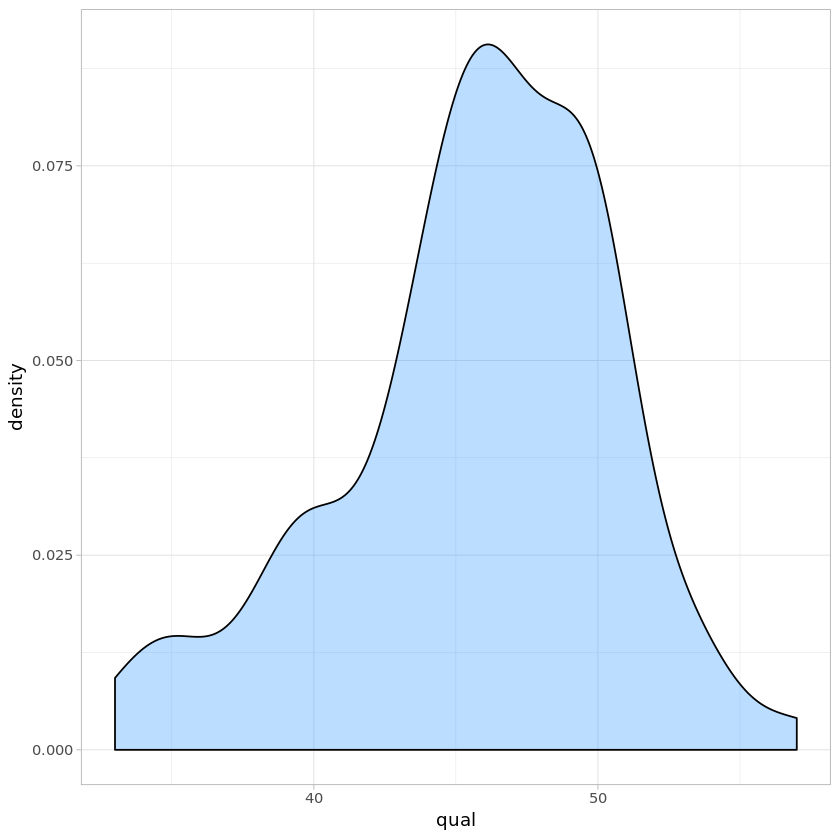

In [5]:
## Now we will plot the distribution of the quality in our subsampled vcf file
a <- ggplot(var_qual, aes(qual)) + geom_density(fill = "dodgerblue1", colour = "black", alpha = 0.3)
a + theme_light()

Quality scores are actually very high for our sites. Phred score (x-axis) of 30 represents a 1 in 1000 chance that our SNP call is erroneous. Clearly most sites exceed this - suggesting we have a lot of high confidence calls. Lets sett a minimum threshold of 30. 

**Variant mean depth**
This is essentially the number of reads that have mapped to the variant possition. The output generated with vcftools is the mean of the read depth across all individuals, for both alleles at a position and is not partitioned between the reference and the alternative.

In [6]:
#Reading the data
var_depth <- read_delim("./vcftools-out/vcftools-out.ldepth.mean", delim = "\t",
           col_names = c("chr", "pos", "mean_depth", "var_depth"), skip = 1)


Parsed with column specification:
cols(
  chr = col_character(),
  pos = col_double(),
  mean_depth = col_double(),
  var_depth = col_double()
)


In [7]:
print(var_depth)

# A tibble: 80 x 4
   chr       pos mean_depth var_depth
   <chr>   <dbl>      <dbl>     <dbl>
 1 chrY  2841557       4.25     28.2 
 2 chrY  2841960       7.19     67.6 
 3 chrY  2844190       7.41     71.1 
 4 chrY  2854791       5.02     37.6 
 5 chrY  2954097       1.94      7.04
 6 chrY  2961454       8.11     84.6 
 7 chrY  3579386       7.90     79.5 
 8 chrY  5056397       8.13     59.9 
 9 chrY  5057254       8.33     90.0 
10 chrY  5098448       7.33     67.2 
# … with 70 more rows


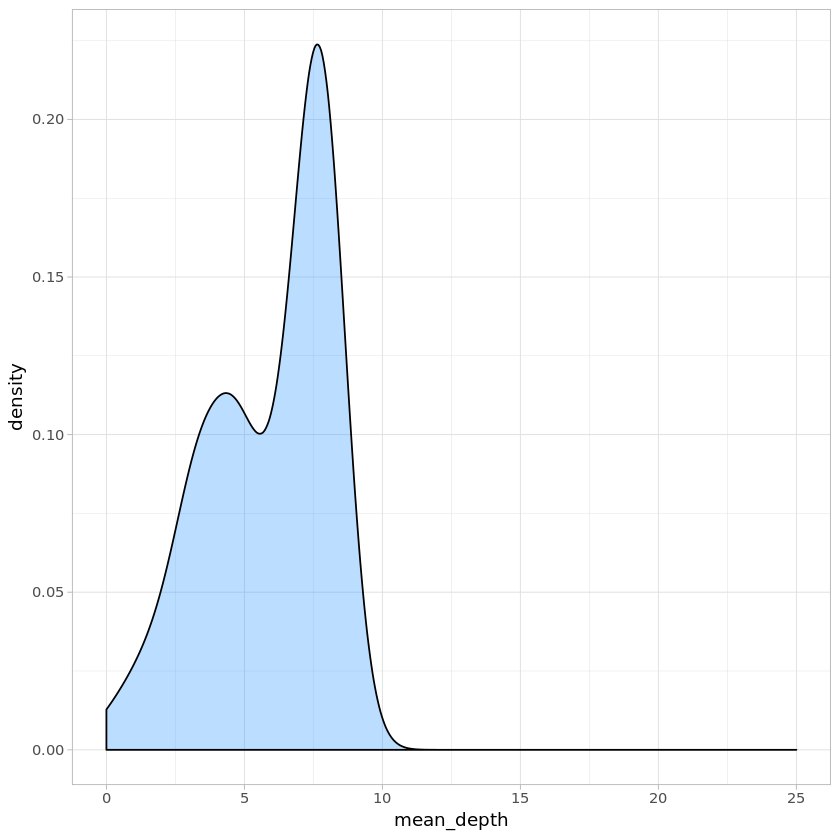

In [11]:
#Visualizing the distribution
a <- ggplot(var_depth, aes(mean_depth)) + geom_density(fill = "dodgerblue1", colour = "black", alpha = 0.3)
a + theme_light() + xlim(0, 25)

In [9]:
summary(var_depth$mean_depth)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
0.01559 4.28648 6.67234 5.85623 7.81880 8.82036 

We could set our minimum coverage at the 5 and 95% quantiles but we should keep in mind that the more reads that cover a site, the higher confidence our basecall is.
Aparently, we don't have regions showing extremely high coverage and this likely reflects mapping/assembly quality. Usually a good rule of thumb is something the mean depth x 2 - so in this case we could set our maximum depth at 12x.
**So we will set our minimum depth to 5x and our maximum depth to 12x**.

**Variant missingness**
Next up we will look at the proportion of missingness at each variant. This is a measure of how many individuals lack a genotype at a call site.One thing to keep in mind here is that different datasets will likely have different missingness profiles, although you would hope the majority share a subset.

In [12]:
var_miss <- read_delim("././vcftools-out/vcftools-out.lmiss", delim = "\t",
                       col_names = c("chr", "pos", "nchr", "nfiltered", "nmiss", "fmiss"), skip = 1)

Parsed with column specification:
cols(
  chr = col_character(),
  pos = col_double(),
  nchr = col_double(),
  nfiltered = col_double(),
  nmiss = col_double(),
  fmiss = col_double()
)


In [13]:
print (var_miss)

# A tibble: 80 x 6
   chr       pos   nchr nfiltered nmiss     fmiss
   <chr>   <dbl>  <dbl>     <dbl> <dbl>     <dbl>
 1 chrY  2841557 401286         0  1884 0.00469  
 2 chrY  2841960 401286         0    70 0.000174 
 3 chrY  2844190 401286         0    32 0.0000797
 4 chrY  2854791 401286         0   394 0.000982 
 5 chrY  2954097 401286         0   528 0.00132  
 6 chrY  2961454 401286         0     8 0.0000199
 7 chrY  3579386 401286         0    42 0.000105 
 8 chrY  5056397 401286         0  4384 0.0109   
 9 chrY  5057254 401286         0    68 0.000169 
10 chrY  5098448 401286         0    30 0.0000748
# … with 70 more rows


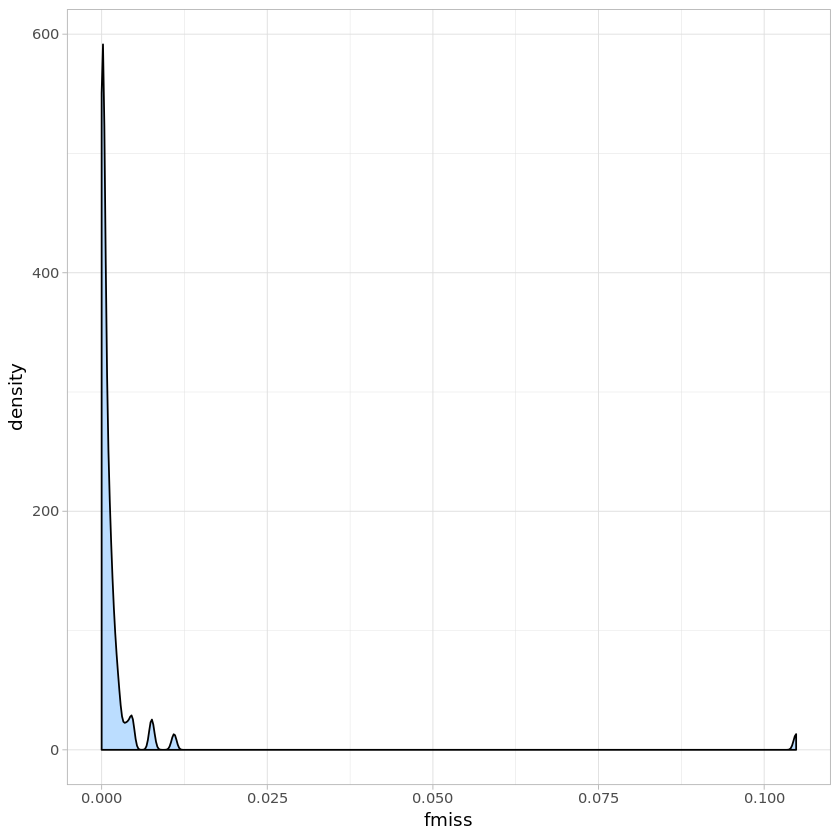

In [20]:
a <- ggplot(var_miss, aes(fmiss)) + geom_density(fill = "dodgerblue1", colour = "black", alpha = 0.3)
a + theme_light()

Our data has a very promising missingness profile - clearly most individuals have a call at almost every site.

In [15]:
#Checking in detail
summary(var_miss$fmiss)

     Min.   1st Qu.    Median      Mean   3rd Qu.      Max. 
0.000e+00 6.853e-05 3.813e-04 2.381e-03 1.322e-03 1.048e-01 

Most sites have low missing data. This means we can be quite conservative when we set our missing data threshold. We will remove all sites where over 10% of individuals are missing a genotype. One thing to note here is that vcftools inverts the direction of missigness, so our 10% threshold means we will tolerate 90% missingness. Typically missingness of 75-95% is used.

**Minor Allele Frecuency**
Last of all for our per variant analyses, we will take a look at the distribution of allele frequencies. This will help inform our minor-allele frequency (MAF) thresholds.

In [22]:
var_freq <- read_delim("././vcftools-out/./vcftools-out.frq", delim = "\t",
                       col_names = c("chr", "pos", "nalleles", "nchr", "a1", "a2"), skip = 1)

Parsed with column specification:
cols(
  chr = col_character(),
  pos = col_double(),
  nalleles = col_double(),
  nchr = col_double(),
  a1 = col_double(),
  a2 = col_double()
)


In [23]:
print(var_freq)

# A tibble: 76 x 6
   chr       pos nalleles   nchr    a1         a2
   <chr>   <dbl>    <dbl>  <dbl> <dbl>      <dbl>
 1 chrY  2841557        2 399402 1.000 0.00000250
 2 chrY  2841960        2 401216 1.000 0.00000249
 3 chrY  2844190        2 401254 1.000 0.00000249
 4 chrY  2854791        2 400892 1.000 0.00000998
 5 chrY  2954097        2 400758 1.000 0.00000749
 6 chrY  2961454        2 401278 1.000 0.00000249
 7 chrY  3579386        2 401244 1.000 0.00000249
 8 chrY  5057254        2 401218 1.000 0.00000249
 9 chrY  5098448        2 401256 1.000 0.00000498
10 chrY  5099775        2 401248 1.000 0.0000125 
# … with 66 more rows


In [24]:
# find minor allele frequency
var_freq$maf <- var_freq %>% select(a1, a2) %>% apply(1, function(z) min(z))

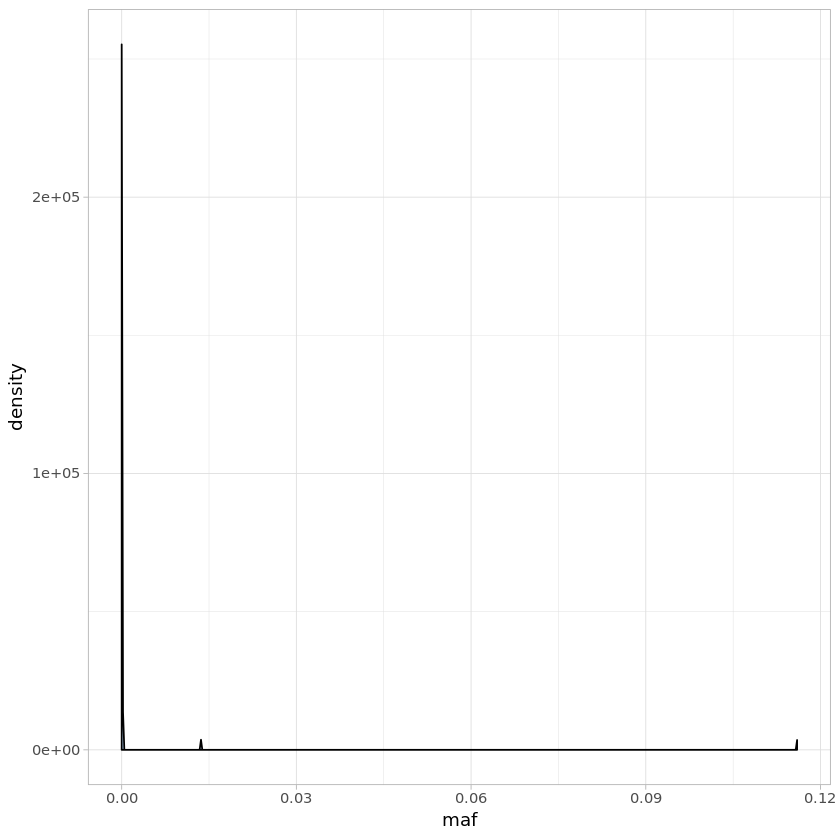

In [25]:
# Plot the MAF distribution
a <- ggplot(var_freq, aes(maf)) + geom_density(fill = "dodgerblue1", colour = "black", alpha = 0.3)
a + theme_light()

The distribution might look a little odd.Nonetheless, it is clear that a large number of variants have verylow frequency alleles. We can also look at the distribution in more detail:

In [26]:
summary(var_freq$maf)

     Min.   1st Qu.    Median      Mean   3rd Qu.      Max. 
2.490e-06 2.490e-06 2.500e-06 1.713e-03 7.480e-06 1.160e-01 

With 16 individuals, there are 28 alleles for a given site. Therefore MAF = 0.04 is equivalent to a variant occurring as one allele in a single individual (i.e. 28 * 0.04 = 1.12). Alternatively, an MAF of 0.1 would mean that any allele would need to occur at least twice (i.e. 28 * 0.1 = 2.8).

Setting MAF cutoffs is actually not that easy or straightforward. Hard MAF filtering (i.e. setting a high threshold) can severely bias estimation of the site frequency spectrum and cause problems with demographic analyses. Similarly, an excesss of low frequency, ‘singleton’ SNPs (i.e. only occurring in one individual) can mean you keep many uniformative loci in your dataset that make it hard to model things like population structure.

Usually then, it is best practice to produce one dataset with a good MAF threshold and keep another without any MAF filtering at all. For now however, we will set our MAF to 0.1

**INDIVIDUAL BASED ANALYSIS**

As well as a our per variant statistics we generated earlier, we also calculated some individual metrics too. We can look at the distribution of these to get an idea whether some of our individuals have not sequenced or mapped as well as others. This is good practice to do with a new dataset. A lot of these statistics can be compared to other measures generated from the data (i.e. principal components as a measure of population structure) to see if they drive any apparent patterns in the data.

**Mean Depth per individual**

In [27]:
ind_depth <- read_delim("./vcftools-out/vcftools-out.idepth", delim = "\t",
                        col_names = c("ind", "nsites", "depth"), skip = 1)

Parsed with column specification:
cols(
  ind = col_double(),
  nsites = col_double(),
  depth = col_double()
)


In [48]:
print(ind_depth)

# A tibble: 200,643 x 3
       ind nsites  depth
     <dbl>  <dbl>  <dbl>
 1 2539439     80  0    
 2 4913701     80 13.9  
 3 3797145     80  0    
 4 1570697     80 12.2  
 5 3311653     80  0    
 6 1029345     80  0.075
 7 3058491     80  0    
 8 5231295     80 11.9  
 9 1368164     80  0.2  
10 5864708     80 13.3  
# … with 200,633 more rows


`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


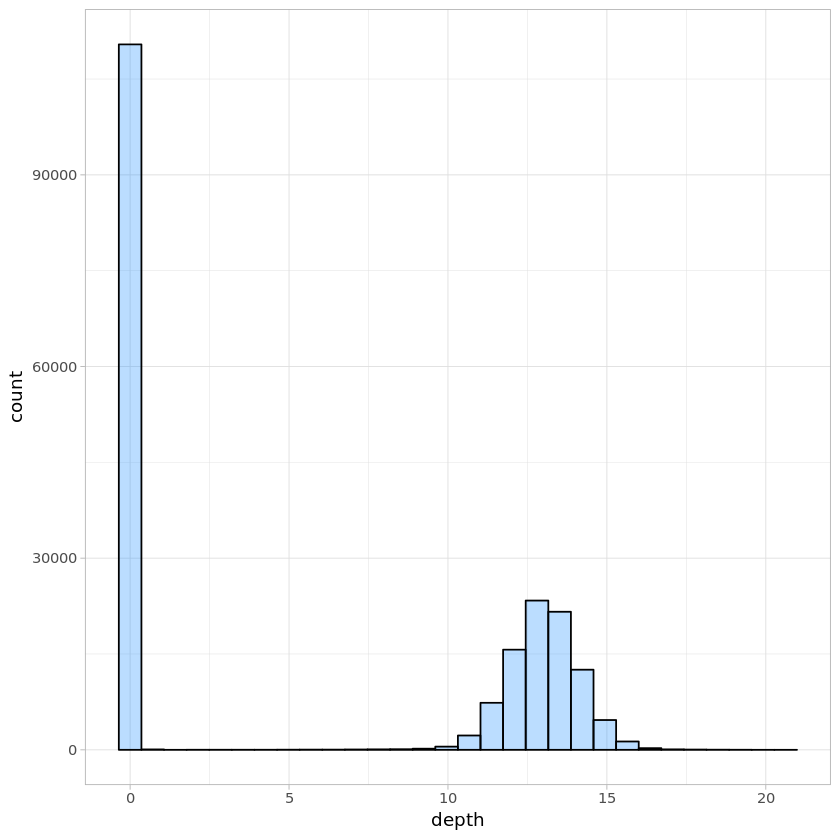

In [29]:
a <- ggplot(ind_depth, aes(depth)) + geom_histogram(fill = "dodgerblue1", colour = "black", alpha = 0.3)
a + theme_light()

In [31]:
summary(ind_depth$depth)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
 0.0000  0.0000  0.0875  5.8562 12.8750 20.6250 

**Proportion of missing data per individual**


In [33]:
ind_miss  <- read_delim("./vcftools-out/vcftools-out.imiss", delim = "\t",
                        col_names = c("ind", "ndata", "nfiltered", "nmiss", "fmiss"), skip = 1)

Parsed with column specification:
cols(
  ind = col_double(),
  ndata = col_double(),
  nfiltered = col_double(),
  nmiss = col_double(),
  fmiss = col_double()
)


`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


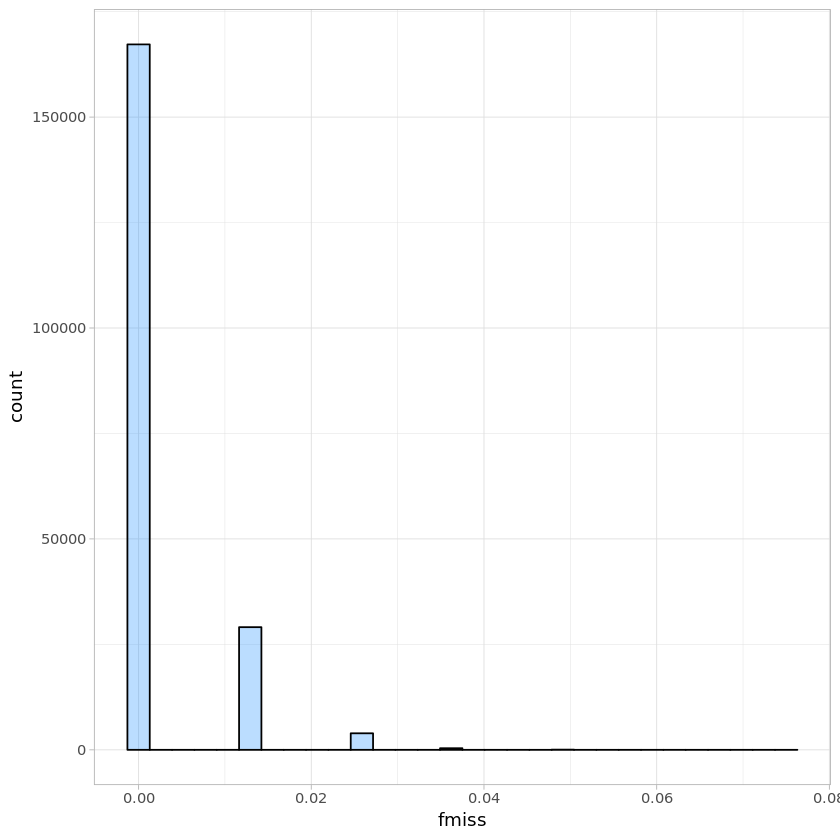

In [34]:
a <- ggplot(ind_miss, aes(fmiss)) + geom_histogram(fill = "dodgerblue1", colour = "black", alpha = 0.3)
a + theme_light()

Again this shows us, the proportion of missing data per individual is very small indeed. It ranges from 0.00-0.08, so we can safely say our individuals sequenced well.

**Heterozygosity and inbreeding coefficient per individual**

In [37]:
ind_het <- read_delim("./vcftools-out/vcftools-out.het", delim = "\t",
           col_names = c("ind","ho", "he", "nsites", "f"), skip = 1)

Parsed with column specification:
cols(
  ind = col_double(),
  ho = col_double(),
  he = col_double(),
  nsites = col_double(),
  f = col_double()
)


In [39]:
print(ind_het)

# A tibble: 200,643 x 5
       ind    ho    he nsites     f
     <dbl> <dbl> <dbl>  <dbl> <dbl>
 1 2539439    76  75.8     76  1   
 2 4913701    76  75.8     76  1   
 3 3797145    76  75.8     76  1   
 4 1570697    76  75.8     76  1   
 5 3311653    76  75.8     76  1   
 6 1029345    76  75.8     76  1   
 7 3058491    76  75.8     76  1   
 8 5231295    74  74.8     75 -3.29
 9 1368164    76  75.8     76  1   
10 5864708    75  75.8     76 -3.29
# … with 200,633 more rows


`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


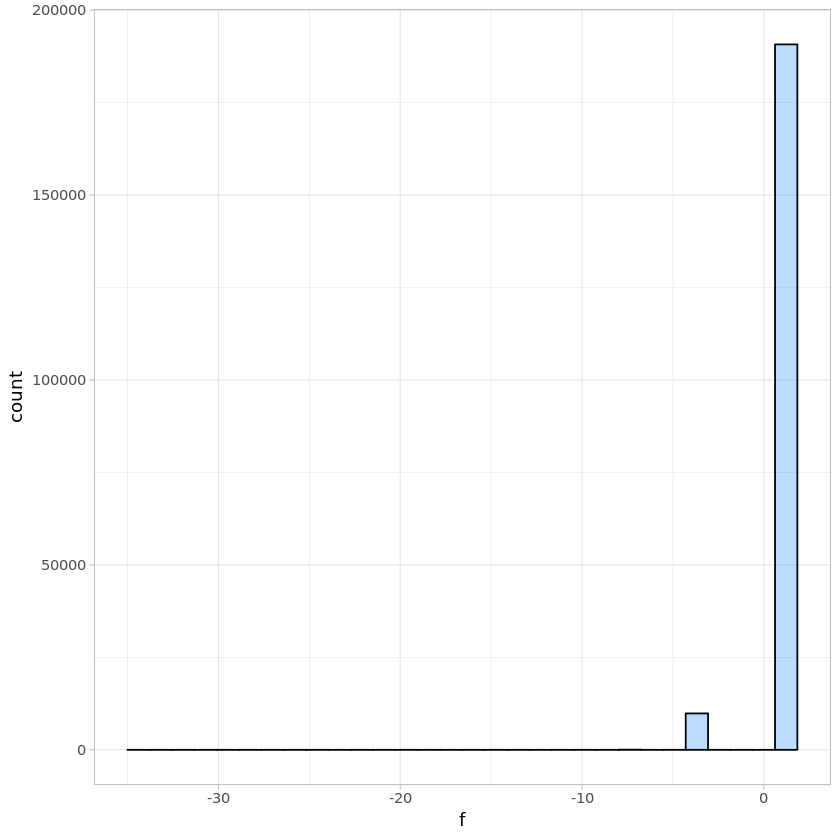

In [36]:
a <- ggplot(ind_het, aes(f)) + geom_histogram(fill = "dodgerblue1", colour = "black", alpha = 0.3)
a + theme_light()

In [40]:
summary(ind_het$f)

    Min.  1st Qu.   Median     Mean  3rd Qu.     Max. 
-34.6153   1.0000   1.0000   0.7864   1.0000   1.0000 

There is an individual who shows high levels of allelic dropout (strongly negative F) we need to double check it to see if is necessary to remove it. Apparently, there is not DNA contamination in our samples (highly positive F).

**OUR FILTERS IN SUMMARY**
**MAF:** 0.1
**MISS:** 0.9
**QUAL:** 30
**MIN_DEPTH:** 5
**MAX_DEPTH:** 12